# Import libraries

In [15]:
from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders, create_subset_loader
from src.preprocessing.dataLoader_vi import SiameseNetworkDataset
from src.ml.resNet18 import SiameseNetwork
from src.ml.loss_utils import ContrastiveLoss, ArcFaceLoss, MultiSimilarityLoss
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch

# 1. Load the data

In [16]:
import yaml

# Load config from YAML
with open("config/config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract sections
PRE = config["PREPROCESSING"]
TRAIN = config["TRAINING"]

# Set constants from preprocessing config
IMAGE_DIR = PRE["image_dir"]
LABEL_FILE = PRE["label_file"]
PARTITION_FILE = PRE["partition_file"]
BATCH_SIZE = PRE["batch_size"]
M_PER_SAMPLE = PRE["m_per_sample"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set constants from training config
LR = TRAIN["lr"]
SCHEDULING = TRAIN["scheduling"]
WEIGHT_DECAY = TRAIN["weight_decay"]
NUM_EPOCHS = TRAIN["num_epochs"]
PATIENCE = TRAIN["patience"]
LOSS_TYPE = TRAIN["loss_type"]
DATASET_NAME = "celebA"# "celebA" # vi

In [17]:
if DATASET_NAME == "celebA":
    # Load datasets
    train_loader, val_loader, test_loader = get_partitioned_dataloaders(
        image_dir=IMAGE_DIR,
        label_file=LABEL_FILE,
        m_per_sample=M_PER_SAMPLE,
        partition_file=PARTITION_FILE,
        batch_size=BATCH_SIZE,
        output_format = "others"
    )

    train_loader = create_subset_loader(train_loader, 5000)
    test_dataloader= create_subset_loader(train_loader, 1000)
else:
    # Load the training dataset
    folder_dataset = datasets.ImageFolder(root="data/v2/data/faces/training/")

    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])

    # Initialize the network
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                            transform=transformation)
    train_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=64)

    # Locate the test dataset and load it into the SiameseNetworkDataset
    folder_dataset_test = datasets.ImageFolder(root="data/v2/data/faces/testing/")
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transformation)
    test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Create the model

In [18]:
model = SiameseNetwork()

# Train Model

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SiameseNetwork().to(DEVICE)
loss_type = LOSS_TYPE

if loss_type == "contrastive":
    criterion = ContrastiveLoss(margin=20)
elif loss_type == "arcface":
    criterion = ArcFaceLoss(num_classes=20000, embedding_size=256)
elif loss_type == "multisimilarity":
    import pytorch_metric_learning.losses as losses
    criterion = losses.MultiSimilarityLoss(alpha=2, beta=50, base=0.5)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0005)


In [20]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [22]:
from tqdm import tqdm

counter = []
loss_history = [] 
iteration_number = 0
cum_loss = 0

# Iterate through the epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    # tqdm progress bar for batches
    pbar = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Training Epoch {epoch+1}")
    
    for i, (img0, img1, label, label0, label1) in pbar:
        # Send the images and labels to DEVICE
        img0, img1, label, label0, label1 = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE), label0.to(DEVICE), label1.to(DEVICE)
        
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)

        # Compute loss
        if loss_type == "contrastive":
            loss = criterion(output1, output2, label)
        elif loss_type == "multisimilarity":
            embeddings = torch.cat([output1, output2])
            labels = torch.cat([label0, label1])
            loss = criterion(embeddings, labels)
        elif loss_type == "arcface":
            loss = criterion(output1, output2, label0, label1)

        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()

        # Logging every 10 batches
        if i % 10 == 0:
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.item())
        
        # Update tqdm description
        pbar.set_postfix({'Avg Loss': cum_loss / (i + 1)})

show_plot(counter, loss_history)



Epoch 1/10


Training Epoch 1:   2%|▏         | 5/313 [00:31<32:07,  6.26s/it, Avg Loss=187]


KeyboardInterrupt: 

# TEST

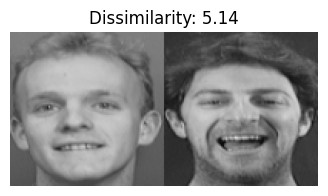

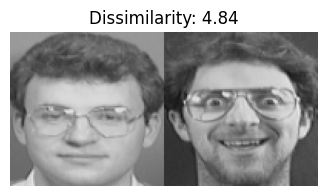

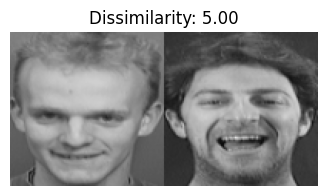

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F

def imshow(img, title=None):
    npimg = img.numpy()
    plt.figure(figsize=(4, 2))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Set your model to eval mode
net.eval()

for i in range(3):
    # Get one sample (batch of 1)
    img1, _, _, label1, _ = next(iter(test_dataloader))
    img2, _, _, label2, _ = next(iter(test_dataloader))

    # Optional: move to GPU if needed

    # Get embeddings
    with torch.no_grad():
        emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))
        euclidean_distance = F.pairwise_distance(emb1, emb2)

    # Concatenate images for display
    concatenated = torch.cat((img1[0], img2[0]), 2)  # side by side: concat on width (dim=2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')


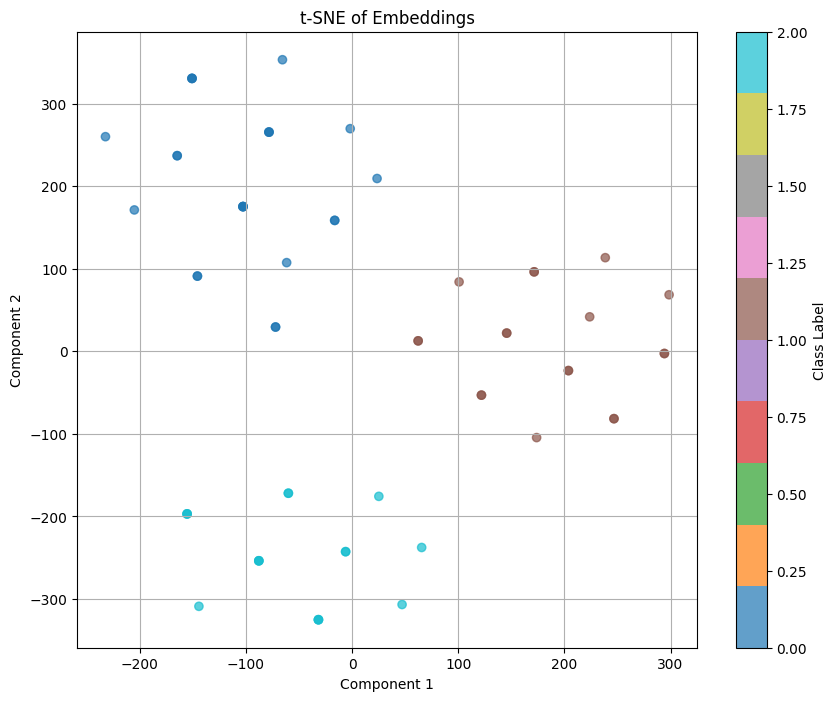

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import numpy as np

embeddings = []
labels = []

# Collect N samples
N = 200  # or more for better visualization
iterator1 = iter(test_dataloader)
iterator2 = iter(test_dataloader)

for _ in range(N):
    try:
        img1, _, _, label1, _ = next(iterator1)
        img2, _, _, label2, _ = next(iterator2)
    except StopIteration:
        break

    with torch.no_grad():
        emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))

    # Collect embeddings and labels
    embeddings.append(emb1.squeeze(0).cpu().numpy())
    labels.append(label1.item())

    embeddings.append(emb2.squeeze(0).cpu().numpy())
    labels.append(label2.item())

# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


# Plot the results

In [ ]:
! mlflow ui --port 5000